# Reinforcement Learning

# 7. Parametric Bandits


The objective of this lab is to recommend contents (here movies) using **parametric bandits**. The rewards are binary (like or dislike).


## Imports


In [951]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

You will need `ipywidgets` to simulate the interactions with the user.


In [952]:
#!pip install ipywidgets

In [953]:
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout

In [954]:
#!pip install scikit-learn

In [955]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import spearmanr

## Data


We work on a catalogue of 1037 movies available in 2015.


In [956]:
catalogue = pd.read_pickle("./data/movie_database.pickle")

In [957]:
len(catalogue)

1037

In [958]:
catalogue.head()

,Actors,Awards,Country,Director,Genre,Language,Rated,Released,Title,imdbID,imdbRating,Metascore,Box_office,imdbVotes,Runtime,poster
0,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...",Won 1 Oscar. Another 15 wins & 18 nominations.,[USA],[Irvin Kershner],"[Action, Adventure, Fantasy]",[English],[PG],1980-06-20,Star Wars: Episode V - The Empire Strikes Back,tt0080684,8.8,79.0,290158751.0,799579.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,"[Kareem Abdul-Jabbar, Lloyd Bridges, Peter Gra...",Nominated for 1 Golden Globe. Another 2 wins &...,[USA],"[Jim Abrahams, David Zucker, Jerry Zucker]",[Comedy],[English],[PG],1980-07-02,Airplane!,tt0080339,7.8,NaN,83400000.0,154994.0,88.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,"[John Belushi, Dan Aykroyd, James Brown, Cab C...",1 win.,[USA],[John Landis],"[Action, Comedy, Crime]",[English],[R],1980-06-20,The Blues Brothers,tt0080455,7.9,NaN,54200000.0,138196.0,133.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,"[Jack Nicholson, Shelley Duvall, Danny Lloyd, ...",3 wins & 5 nominations.,"[USA, UK]",[Stanley Kubrick],"[Drama, Horror]",[English],[R],1980-05-23,The Shining,tt0081505,8.4,61.0,NaN,584323.0,146.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,"[Anthony Hopkins, John Hurt, Anne Bancroft, Jo...",Nominated for 8 Oscars. Another 10 wins & 14 n...,"[USA, UK]",[David Lynch],"[Biography, Drama]",[English],[PG],1980-10-10,The Elephant Man,tt0080678,8.2,NaN,NaN,156572.0,124.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


The features are the following:

| Column     | Description                                      | Type             |
| :--------- | :----------------------------------------------- | :--------------- |
| Actors     | Actors staring                                   |  list of strings |
| Awards     | Awards received                                  |  string          |
| Country    | Country of origin                                | list of strings  |
| Director   | Director(s) of the movie                         | list of strings  |
| Genre      | Genres (Action, ...)                             | list of strings  |
| Language   | Language(s) spoken                               | list of strings  |
| Rated      | Public rating (G = General, R = Restricted, ...) |  list of strings |
| Released   | Date of the movie                                |  date            |
| Title      | Title of the movie                               | string           |
| imdbID     | IMDB id                                          | string           |
| imdbRating | IMDB rating (between 0 and 10)                   |  float           |
| Metascore  | Metacritic score (between 0 and 100)             | float            |
| Box_office | Total money generated                            | float            |
| imdbVotes  | Number of IMDB votes                             |  float           |
| Runtime    |  Duration of the movie (in minutes)              | float            |
| poster     |  Poster of the movie (jpg)                       |  binary string   |


In [959]:
# Display the posters
def get_poster(k, scale=1):
    return Image(
        value=catalogue.loc[k].poster,
        format="jpg",
        width=130 * scale,
        height=200 * scale,
    )


def display_posters(index=None, n_col=5, n_rows=4):
    if index is None:
        index = np.arange(len(catalogue))
    if len(index):
        n_rows = min(n_rows, int(np.ceil(len(index) / n_col)))
        grid = GridspecLayout(n_rows, n_col)
        k = 0
        for i in range(n_rows):
            for j in range(n_col):
                if k < len(index):
                    grid[i, j] = get_poster(index[k])
                k += 1
        return grid

In [960]:
display_posters()

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Features

We will describe each movie by some features, for instance its genre.


In [961]:
mlb = MultiLabelBinarizer()

In [962]:
movies = pd.DataFrame(mlb.fit_transform(catalogue["Genre"]), columns=mlb.classes_)

In [963]:
movies.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [964]:
movies.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'],
      dtype='object')

## User

Each user will be modeled by a vector of weights (positive or negative) on each feature.


In [965]:
user = pd.DataFrame(0, index=[0], columns=movies.columns)
user["Action"] = 2
user["Crime"] = 1
user["Sci-Fi"] = -2

## To do

- Display the favorite movies of this user.
- Test another user, and quantify their similarity (e.g., proportion of common top-100 movies).


In [966]:
preferences = (movies.dot(user.T)).sort_values(0, ascending=False)
display_posters(preferences.index)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [967]:
user2 = pd.DataFrame(0, index=[0], columns=movies.columns)
user2["Action"] = 3
user2["Fantasy"] = -2

In [968]:
def compute_user_similarity(user1, user2):
    preferences1 = (movies.dot(user1.T)).sort_values(0, ascending=False)[:100]
    preferences2 = (movies.dot(user2.T)).sort_values(0, ascending=False)[:100]

    common_movies = preferences1.index.intersection(preferences2.index)
    return len(common_movies) / 100

In [969]:
print(f"Proportion of top-100 movies in common: {compute_user_similarity(user, user2)}")

Proportion of top-100 movies in common: 0.31


## Offline learning

We start with offline learning. There are 2 steps:

1. Collect the user's opinion on a few movies (e.g., 10)
2. Rank the other movies by logistic regression.

Let's test that.


In [970]:
# Add a column to record the user's opinion (like / dislike)
movies = movies.assign(like=None)

In [971]:
# Select a random movie (not yet seen by the user)
def select_random_movie():
    index = np.flatnonzero(movies.like.isna())
    if len(index):
        return np.random.choice(index)
    else:
        return np.random.choice(len(movies))

In [972]:
# Create buttons
def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout())


def update_likes(button):
    global movie_id
    movies.loc[movie_id, "like"] = button.description == "like"


def update_poster():
    global movie_id
    img.value = catalogue.loc[movie_id].poster


def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_random_movie()
    update_poster()

In [973]:
# Setting the buttons
left_button = create_expanded_button("like", "success")
right_button = create_expanded_button("dislike", "danger")
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# Setting the movie poster
movie_id = select_random_movie()
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=left_button,
    right_sidebar=right_button,
    center=img,
    pane_widths=[0.3, 0.4, 0.3],
)

AppLayout(children=(Button(button_style='success', description='like', layout=Layout(grid_area='left-sidebar')…

## To do

- Give your opinion on some movies (e.g., 10), making sure that you get a few likes and a few dislikes.
- Apply logistic regression and display the other movies in order of preference (top movies first).
- Give your top-3 and bottom-3 genres, as predicted by the model.


In [974]:
# likes
likes = np.flatnonzero(movies.like == True)
display_posters(likes)

In [975]:
# dislikes
dislikes = np.flatnonzero(movies.like == False)
display_posters(dislikes)

We first fit the logistic regression model on the training set (e.g. the movies we liked/disliked).

Then we predict the probability of liking each (not yet rated) movie and sort them by decreasing probability.


In [976]:
model = LogisticRegression(fit_intercept=False)

# we hard code the user's preferences
for i, idx in enumerate(np.random.choice(len(movies), 20)):
    movies.loc[idx, "like"] = True if i % 2 == 0 else False

y = (movies.like[~movies.like.isna()]).astype(int)
X = movies.drop(columns="like")[~movies.like.isna()]
model.fit(X, y)

LogisticRegression(fit_intercept=False)

In [977]:
recommendations = model.predict_proba(movies.drop(columns="like"))[:, 1]
recommendations = pd.Series(recommendations, index=movies.index).sort_values(
    ascending=False
)
display_posters(recommendations.index)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

In [978]:
# top 3 and bottom 3 genres
model_genres = model.coef_[0]
top_3 = (-model_genres).argsort()[:3]
bottom_3 = model_genres.argsort()[:3]

print(f"Top-3 genres predicted by the model: {movies.columns[top_3].values}")
print(f"Bottom-3 genres predicted by the model: {movies.columns[bottom_3].values}")

Top-3 genres predicted by the model: ['Drama' 'Romance' 'Family']
Bottom-3 genres predicted by the model: ['Thriller' 'Action' 'Mystery']


## Online learning


We now learn the user preferences online, as they come. For that, we use a Bayesian algorithm inspired by Thompson sampling.

On each feedback provided by the user:

1. (Learning) The parameter (vector of weights) is learned.
2. (Sampling) A new parameter is sampled, assuming a Gaussian distribution.
3. (Action) The top movie for this new parameter, among movies not yet seen by the user, is proposed.

Note that:

- In step 1, we retrain the estimator **from scratch**, using logistic regression on all training data samples (**no** online estimation).
- In step 2, we discard correlations (**diagonal** covariance matrix).


## To do

- Complete the function `select_bayes` below.
- Test it on some movies (e.g., 10), until you get a few likes and a few dislikes.
- Display the other movies in order of preference (top movies first).


In [979]:
model = LogisticRegression(fit_intercept=False)

In [980]:
def select_bayes(movies, model):
    if set(movies.like) == {True, False, None}:
        # to be completed (learning, sampling, action)

        # 1. Learning
        y = np.array((movies.like[~movies.like.isna()]).astype(int))
        X = np.array(movies.drop(columns="like")[~movies.like.isna()])
        model.fit(X, y)

        # 2. Sampling
        mu = model.coef_.flatten()
        probabilities = np.array(model.predict_proba(X)[:, 1])
        W = np.diag(probabilities * (1 - probabilities))
        Hessian = (X.T @ W @ X) + np.eye(X.shape[1])  # H = X.T*W*X + I*lambda
        cov = np.linalg.inv(Hessian)
        cov = np.diag(np.diag(cov))

        new_weights = np.random.multivariate_normal(mu, cov)

        # 3. Action
        unseen_movies = movies[movies.like.isna()]
        X_unseen = unseen_movies.drop(columns="like")

        scores = X_unseen @ new_weights
        recommended_index = np.argmax(scores)

        return recommended_index
    else:
        return select_random_movie()

In [981]:
# reset
movies = movies.assign(like=None)

In [982]:
def on_button_clicked(button):
    global movie_id
    update_likes(button)
    movie_id = select_bayes(movies, model)
    update_poster()

In [983]:
# Setting the buttons
left_button = create_expanded_button("like", "success")
right_button = create_expanded_button("dislike", "danger")
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# Setting the movie poster
movie_id = select_random_movie()
img = get_poster(movie_id, scale=1.5)

# Display
AppLayout(
    left_sidebar=left_button,
    right_sidebar=right_button,
    center=img,
    pane_widths=[0.3, 0.4, 0.3],
)

AppLayout(children=(Button(button_style='success', description='like', layout=Layout(grid_area='left-sidebar')…

In [984]:
# we hard code the user's preferences
for i in range(20):
    movies.loc[movie_id, "like"] = True if i % 2 == 0 else False
    movie_id = select_bayes(movies, model)

X = np.array(movies.drop(columns="like")[movies.like.isna()])

recommendations = model.predict_proba(X)[:, 1]
recommendations = pd.Series(
    recommendations,
).sort_values(ascending=False)

display_posters(recommendations.index)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

## Analysis

Finally, we would like to assess the quality of our bandit algorithm.

## To do

- Choose a user, that is a parameter $\theta$ (vector of weights).
- Provide the answers of this user to the movies proposed by the algorithm, assuming binary rewards, with mean
  $$
  q(a) = \frac 1 {1 + e^{-\theta^T a}}
  $$
  where $a$ is the action (= movie proposed by the algorithm).
- Make sure that a reasonable fraction of movies are liked (e.g., between 10\% and 90\%). Otherwise, update $\theta$.
- Simulate an interaction of this user with the recommender system over 100 movies.
- Compute the [Spearman's correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) of the ranking of the unseen movies provided by the algorithm, compared to the ground-truth ranking.
- Plot the evolution of this coefficient with respect to the number of movies seen by the user, from 1 to 100.
- Give the top-3 and bottom-3 genres, as predicted by the model, and compare to the ground-truth.
- Do the same experiments with other features (e.g., actors, actors + genres, actors + director + genres).


In [985]:
model = LogisticRegression(fit_intercept=False)

movies = movies.assign(like=None)
theta_user = np.random.randn(movies.drop(columns="like").shape[1])

# Initialize the model parameters
model.coef_ = np.array([[0.0] * movies.drop(columns="like").shape[1]])
model.classes_ = np.array([0.0, 1.0])
model.intercept_ = 0.0

while True:
    q_a = 1 / (1 + np.exp(-movies.drop(columns="like").values @ theta_user))
    if 0.1 <= np.mean(q_a) <= 0.9:
        break
    theta_user = np.random.randn(movies.drop(columns="like").shape[1])

print(f"Fraction of movies liked by the generated user: {np.mean(q_a):.2f}")

Fraction of movies liked by the generated user: 0.42


In [986]:
def user_feedback(movies, theta_user):
    q_a = 1 / (1 + np.exp(-movies @ theta_user))
    return np.random.binomial(1, q_a)

In [987]:
def simulation(movies, n_movies=100):
    spearman_correlations = []
    movies_seen = []

    for _ in range(n_movies):
        idx_new_movie = select_bayes(movies, model)

        # simulate that the user has watched the movie and provided feedback (like / dislike)
        movie_features = movies.loc[idx_new_movie].drop(labels="like")
        feedback = user_feedback(movie_features, theta_user)
        movies.loc[idx_new_movie, "like"] = feedback
        movies_seen.append(idx_new_movie)

        # get the ranking of the unseen movies
        unseen_movies = movies[movies.like.isna()]
        model_ranking = model.predict_proba(
            np.array(unseen_movies.drop(columns="like"))
        )[:, 1]
        ground_truth_ranking = 1 / (
            1 + np.exp(-unseen_movies.drop(columns="like").values @ theta_user)
        )

        # remove the constants ranking made by the model:
        # if all the movies have the same ranking
        # this means that the model has not been trained yet
        if np.all(model_ranking == model_ranking[0]):
            continue

        spearman_corr, _ = spearmanr(model_ranking, ground_truth_ranking)
        spearman_correlations.append(spearman_corr)

    return spearman_correlations

In [988]:
def plot_spearman_correlation(spearman_correlations, title):
    plt.figure(figsize=(10, 5))
    plt.plot(spearman_correlations)
    plt.xlabel("Number of movies watched")
    plt.ylabel("Spearman correlation")
    plt.title(title)
    plt.show()

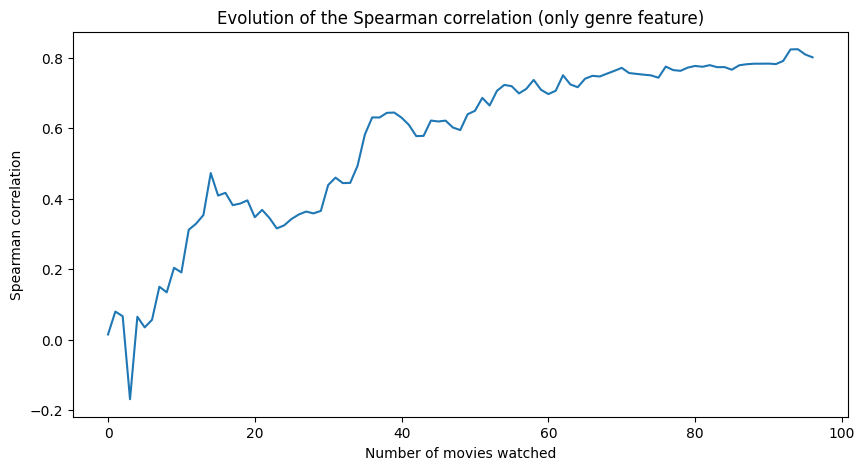

In [989]:
spearman_correlations = simulation(movies)
plot_spearman_correlation(
    spearman_correlations, "Evolution of the Spearman correlation (only genre feature)"
)

As we can see, the algorithm is able to learn the user preferences and provide good recommendations.

The spearman correlation increases with the number of movies seen by the user, stabilizing at a high value.


In [990]:
top_3_model = (-model.coef_[0]).argsort()[:3]
top_3_ground_truth = (-theta_user).argsort()[:3]

bottom_3_model = model.coef_[0].argsort()[:3]
bottom_3_ground_truth = theta_user.argsort()[:3]

print(f"Top-3 genres predicted by the model: {movies.columns[top_3_model].values}")
print(f"Top-3 genres in the ground truth: {movies.columns[top_3_ground_truth].values}")

print(
    f"\nBottom-3 genres predicted by the model: {movies.columns[bottom_3_model].values}"
)
print(
    f"Bottom-3 genres in the ground truth: {movies.columns[bottom_3_ground_truth].values}"
)

Top-3 genres predicted by the model: ['Romance' 'Horror' 'Sci-Fi']
Top-3 genres in the ground truth: ['Romance' 'Horror' 'Sci-Fi']

Bottom-3 genres predicted by the model: ['Mystery' 'Drama' 'Adventure']
Bottom-3 genres in the ground truth: ['Family' 'Mystery' 'Music']


We can confirm this finding by looking at the top-3 and bottom-3 genres, which align, even if not perfectly, with the user preferences.


### Experimentation with other features


#### Actors


In [991]:
model = LogisticRegression(fit_intercept=False)

actor_movies = pd.DataFrame(
    mlb.fit_transform(catalogue["Actors"]), columns=mlb.classes_
)
actor_movies = actor_movies.assign(like=None)
theta_user = np.random.randn(actor_movies.drop(columns="like").shape[1])

# Initialize the model parameters
model.coef_ = np.array([[0.0] * actor_movies.drop(columns="like").shape[1]])
model.classes_ = np.array([0.0, 1.0])
model.intercept_ = 0.0

while True:
    q_a = 1 / (1 + np.exp(-actor_movies.drop(columns="like").values @ theta_user))
    if 0.1 <= np.mean(q_a) <= 0.9:
        break
    theta_user = np.random.randn(actor_movies.drop(columns="like").shape[1])

print(f"Fraction of movies liked: {np.mean(q_a):.2f}")

Fraction of movies liked: 0.50


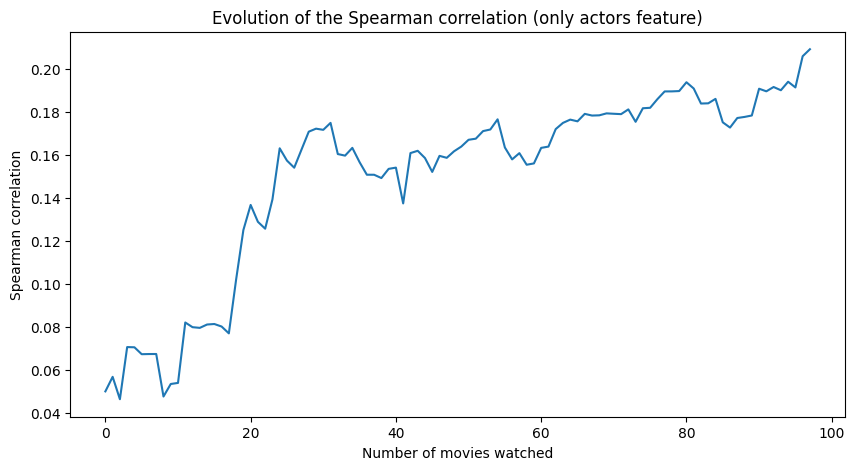

In [992]:
spearman_correlations = simulation(actor_movies)
plot_spearman_correlation(
    spearman_correlations, "Evolution of the Spearman correlation (only actors feature)"
)

Here we use the actors as features. We can see that the algorithm is able to learn the user preferences.

With 100 movies seen, the Spearman correlation isn't as high as with genres. We have low but still increasing values. This indicates that the actors are less discriminative than the genres.

In order to improve the performance, we could train the model on more data.


#### Actors + Genres


In [993]:
model = LogisticRegression(fit_intercept=False)

actor_movies = pd.DataFrame(
    mlb.fit_transform(catalogue["Actors"]), columns=mlb.classes_
)
genre_movies = pd.DataFrame(mlb.fit_transform(catalogue["Genre"]), columns=mlb.classes_)
actor_genre_movies = pd.concat([actor_movies, genre_movies], axis=1)
actor_genre_movies = actor_genre_movies.assign(like=None)
theta_user = np.random.randn(actor_genre_movies.drop(columns="like").shape[1])

# Initialize the model parameters
model.coef_ = np.array([[0.0] * actor_genre_movies.drop(columns="like").shape[1]])
model.classes_ = np.array([0.0, 1.0])
model.intercept_ = 0.0

while True:
    q_a = 1 / (1 + np.exp(-actor_genre_movies.drop(columns="like").values @ theta_user))
    if 0.1 <= np.mean(q_a) <= 0.9:
        break
    theta_user = np.random.randn(actor_genre_movies.drop(columns="like").shape[1])

print(f"Fraction of movies liked: {np.mean(q_a):.2f}")

Fraction of movies liked: 0.67


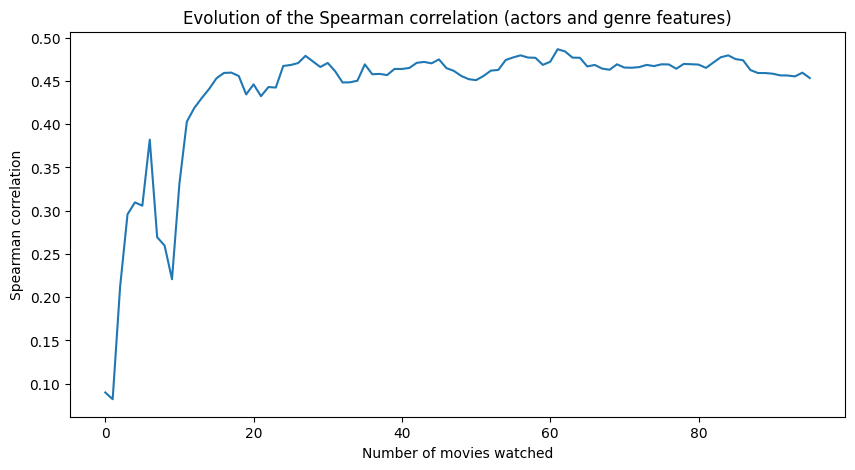

In [994]:
spearman_correlations = simulation(actor_genre_movies)
plot_spearman_correlation(
    spearman_correlations,
    "Evolution of the Spearman correlation (actors and genre features)",
)

In this case, we use both actors and genres as features. The Spearman correlation is higher than with actors only, but lower than with genres only.


#### Actors + Genres + Directors


In [995]:
model = LogisticRegression(fit_intercept=False)

actor_movies = pd.DataFrame(
    mlb.fit_transform(catalogue["Actors"]), columns=mlb.classes_
)
genre_movies = pd.DataFrame(mlb.fit_transform(catalogue["Genre"]), columns=mlb.classes_)
director_movies = pd.DataFrame(
    mlb.fit_transform(catalogue["Director"]), columns=mlb.classes_
)
actor_genre_director_movies = pd.concat(
    [actor_movies, genre_movies, director_movies], axis=1
)
actor_genre_director_movies = actor_genre_director_movies.assign(like=None)
theta_user = np.random.randn(actor_genre_director_movies.drop(columns="like").shape[1])

# Initialize the model parameters
model.coef_ = np.array(
    [[0.0] * actor_genre_director_movies.drop(columns="like").shape[1]]
)
model.classes_ = np.array([0.0, 1.0])
model.intercept_ = 0.0

while True:
    q_a = 1 / (
        1
        + np.exp(-actor_genre_director_movies.drop(columns="like").values @ theta_user)
    )
    if 0.1 <= np.mean(q_a) <= 0.9:
        break
    theta_user = np.random.randn(
        actor_genre_director_movies.drop(columns="like").shape[1]
    )

print(f"Fraction of movies liked: {np.mean(q_a):.2f}")

Fraction of movies liked: 0.55


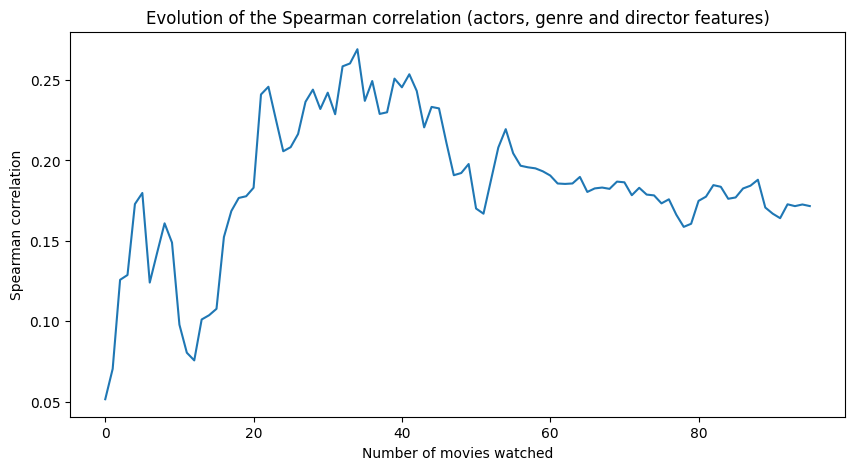

In [996]:
spearman_correlations = simulation(actor_genre_director_movies)
plot_spearman_correlation(
    spearman_correlations,
    "Evolution of the Spearman correlation (actors, genre and director features)",
)

The results are similar to the previous two cases.

This tells us that adding the director doesn't improve the performance of the model.

In all the mixed cases, we have seen that the genres are the most discriminative features, and adding other features is adding noise more than information.
